In [1]:
#1.Importation des librairies

# Data
import pandas as pd
import numpy as np
import seaborn as sns
# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# Keras
from tensorflow import keras
from tensorflow.keras import layers

Type de fleur (0,1,2 → Setosa, Versicolor, Virginica)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   especes            150 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 6.0 KB


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),especes
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),especes
0,6.1,2.8,4.7,1.2,1
1,5.7,3.8,1.7,0.3,0
2,7.7,2.6,6.9,2.3,2
3,6.0,2.9,4.5,1.5,1
4,6.8,2.8,4.8,1.4,1


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),especes
145,6.1,2.8,4.0,1.3,1
146,4.9,2.5,4.5,1.7,2
147,5.8,4.0,1.2,0.2,0
148,5.8,2.6,4.0,1.2,1
149,7.1,3.0,5.9,2.1,2


especes
1    50
0    50
2    50
Name: count, dtype: int64


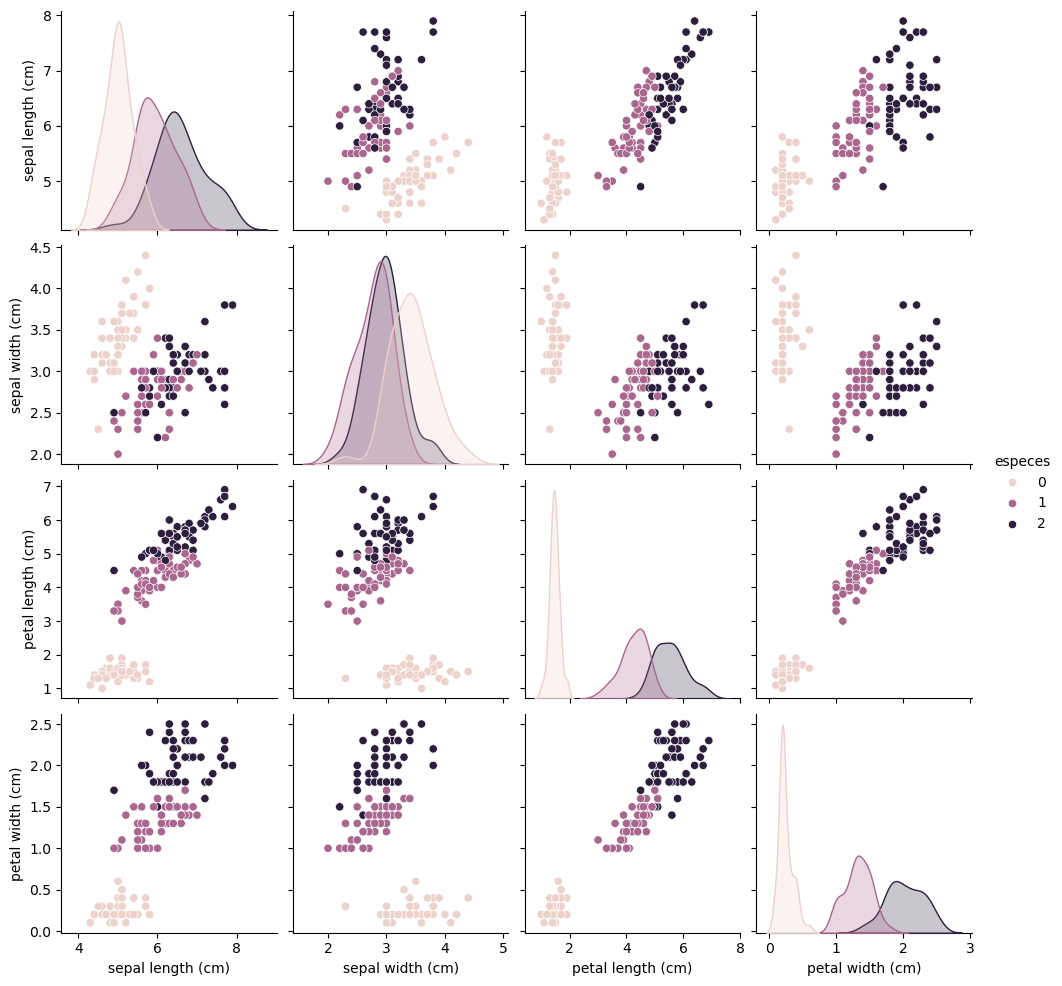

In [2]:
#2.Chargement et exploration du dataset
from sklearn.datasets import load_iris

print('Type de fleur (0,1,2 → Setosa, Versicolor, Virginica)')
# Charger le dataset Iris
iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)

# Ajouter les labels (0, 1, 2)
df['especes'] = iris.target
# Mélanger le dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Visualisation rapide
df.info()#Visualisation rapide des informations générales
display(df.describe())#Description statistique
display(df.head())# Affichage des 5 premieres lignes du dataset
display(df.tail())# Affichage des 5 derniers lignes du dataset
print(df['especes'].value_counts())#Compte des classes

#Pairplot pour visualisation
sns.pairplot(df, hue='especes')

In [3]:
#3.Preparation des données

# Charger le dataset Iris depuis seaborn
df = sns.load_dataset("iris")

# Renommer les colonnes pour correspondre à notre code
df.columns = ["sepal_length", "sepal_width", "petal_length", "petal_width", "especes"]

# Encodage manuel des labels (Setosa=0, Versicolor=1, Virginica=2)
classes = {name: i for i, name in enumerate(df["especes"].unique())}
df["especes"] = df["especes"].map(classes)

# Séparer features et labels
X = df.iloc[:, 0:4].values
y = df["especes"].values

# Normalisation manuelle : (x - mean) / std
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_scaled = (X - X_mean) / X_std

# Split manuel train/test (80% / 20%)
n = len(X_scaled)
indices = np.random.permutation(n)
test_size = int(0.2 * n)

test_idx = indices[:test_size]
train_idx = indices[test_size:]

X_train = X_scaled[train_idx]
y_train = y[train_idx]
X_test = X_scaled[test_idx]
y_test = y[test_idx]


In [4]:
#4.Modele Keras

# Création du modèle
model_keras = keras.Sequential([
    layers.Input(shape=(4,)),
    layers.Dense(16, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(3, activation='softmax')
])

# Compilation
model_keras.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Entraînement
history = model_keras.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=16,
    verbose=0
)

# Évaluation
loss, accuracy = model_keras.evaluate(X_test, y_test, verbose=0)
print("Exactitude du test Keras:", accuracy)


Exactitude du test Keras: 0.9666666388511658


In [5]:
#5.Modele PyTorch

# Tensor conversion
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Dataset + DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Définition du modèle PyTorch
class IrisNet(nn.Module):
    def __init__(self):
        super(IrisNet, self).__init__()
        self.fc1 = nn.Linear(4, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 3)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model_torch = IrisNet()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_torch.parameters(), lr=0.01)

# Entraînement
for epoch in range(50):
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model_torch(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

# Evaluation
with torch.no_grad():
    y_pred = model_torch(X_test_tensor)
    y_pred_classes = torch.argmax(y_pred, axis=1)
    accuracy_torch = (y_pred_classes == y_test_tensor).float().mean()

print("Exactitude du test PyTorch:", accuracy_torch.item())


Exactitude du test PyTorch: 1.0


In [6]:
#6.Comparaison des modèles

def classification_metrics(y_true, y_pred, n_classes=3):
    # Initialisation des compteurs
    tp = np.zeros(n_classes)
    fp = np.zeros(n_classes)
    fn = np.zeros(n_classes)
    support = np.zeros(n_classes)

    # Calcul manuel des TP, FP, FN, support
    for c in range(n_classes):
        tp[c] = np.sum((y_pred == c) & (y_true == c))
        fp[c] = np.sum((y_pred == c) & (y_true != c))
        fn[c] = np.sum((y_pred != c) & (y_true == c))
        support[c] = np.sum(y_true == c)

    # Precision, Recall, F1
    precision = tp / (tp + fp + 1e-12)
    recall    = tp / (tp + fn + 1e-12)
    f1        = 2 * precision * recall / (precision + recall + 1e-12)

    # Accuracy
    accuracy = np.sum(y_true == y_pred) / len(y_true)

    # Affichage du tableau
    print("              precision    recall  f1-score   support")
    for c in range(n_classes):
        print(f"        {c}       {precision[c]:.2f}      {recall[c]:.2f}      {f1[c]:.2f}        {int(support[c])}")

    print(f"\n    accuracy                           {accuracy:.2f}        {len(y_true)}")

    print(f"   macro avg       {precision.mean():.2f}      {recall.mean():.2f}      {f1.mean():.2f}        {len(y_true)}")
    
    weighted_precision = np.sum(precision * support) / np.sum(support)
    weighted_recall    = np.sum(recall    * support) / np.sum(support)
    weighted_f1        = np.sum(f1        * support) / np.sum(support)

    print(f"weighted avg       {weighted_precision:.2f}      {weighted_recall:.2f}      {weighted_f1:.2f}        {len(y_true)}")

y_pred_proba = model_keras.predict(X_test)  # forme (n_samples, 3)
y_pred_keras = np.argmax(y_pred_proba, axis=1)  # classes prédites
print("=== Rapport KERAS ===")
classification_metrics(y_test, y_pred_keras, n_classes=3)

print("\n=== Rapport PYTORCH ===")
classification_metrics(y_test, y_pred_classes.numpy(), n_classes=3)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
=== Rapport KERAS ===
              precision    recall  f1-score   support
        0       1.00      0.89      0.94        9
        1       0.89      1.00      0.94        8
        2       1.00      1.00      1.00        13

    accuracy                           0.97        30
   macro avg       0.96      0.96      0.96        30
weighted avg       0.97      0.97      0.97        30

=== Rapport PYTORCH ===
              precision    recall  f1-score   support
        0       1.00      1.00      1.00        9
        1       1.00      1.00      1.00        8
        2       1.00      1.00      1.00        13

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30


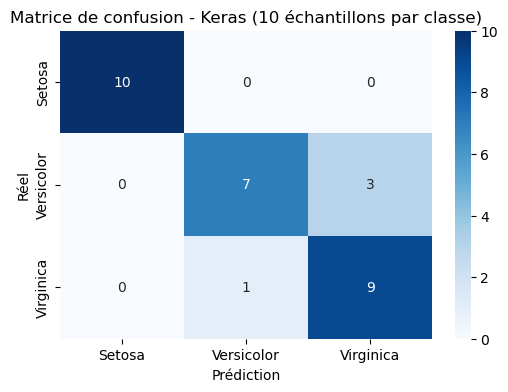

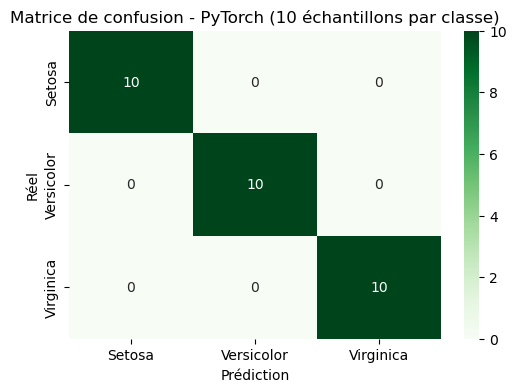

In [7]:
#7.Matrice de confusion
import matplotlib.pyplot as plt
# Sélectionner 10 éléments par classe pour le test
n_samples_per_class = 10
X_subset = []
y_subset = []

for cls in range(3):  # classes 0,1,2
    idx_cls = np.where(y == cls)[0]      # indices de la classe
    selected_idx = idx_cls[:n_samples_per_class]  # prendre les 10 premiers
    X_subset.append(X_scaled[selected_idx])
    y_subset.append(y[selected_idx])

X_subset = np.vstack(X_subset)
y_subset = np.hstack(y_subset)

# Prédictions
y_pred_keras_subset = np.argmax(model_keras.predict(X_subset, verbose=0), axis=1)

X_subset_tensor = torch.tensor(X_subset, dtype=torch.float32)
with torch.no_grad():
    y_pred_torch_subset = torch.argmax(model_torch(X_subset_tensor), axis=1).numpy()

# Fonction matrice de confusion
def confusion_matrix_manual(y_true, y_pred, n_classes=3):
    cm = np.zeros((n_classes, n_classes), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[t, p] += 1
    return cm

# MATRICE KERAS
cm_keras = confusion_matrix_manual(y_subset, y_pred_keras_subset, n_classes=3)
plt.figure(figsize=(6,4))
sns.heatmap(cm_keras, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Setosa','Versicolor','Virginica'],
            yticklabels=['Setosa','Versicolor','Virginica'])
plt.title("Matrice de confusion - Keras (10 échantillons par classe)")
plt.xlabel("Prédiction")
plt.ylabel("Réel")
plt.show()

# MATRICE PYTORCH
cm_torch = confusion_matrix_manual(y_subset, y_pred_torch_subset, n_classes=3)
plt.figure(figsize=(6,4))
sns.heatmap(cm_torch, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Setosa','Versicolor','Virginica'],
            yticklabels=['Setosa','Versicolor','Virginica'])
plt.title("Matrice de confusion - PyTorch (10 échantillons par classe)")
plt.xlabel("Prédiction")
plt.ylabel("Réel")
plt.show()


In [ ]:
#8.Fonctions de prédiction

def predict_flower_keras(model, mean, std):
    """
    Prédit la classe d'une nouvelle fleur avec Keras.
    mean et std sont ceux utilisés pour normaliser le dataset d'entraînement.
    """
    print("\n=== Prédiction Keras d'une nouvelle fleur ===")

    sl = float(input("Longueur sépal (cm) : "))
    sw = float(input("Largeur sépal (cm) : "))
    pl = float(input("Longueur pétal (cm) : "))
    pw = float(input("Largeur pétal (cm) : "))

    # Création du vecteur d'entrée
    flower = np.array([[sl, sw, pl, pw]])
    
    # Normalisation
    flower_scaled = (flower - mean) / std

    # Prédiction
    y_pred = model.predict(flower_scaled, verbose=0)
    pred_class = np.argmax(y_pred, axis=1)[0]

    classes = ["Setosa", "Versicolor", "Virginica"]
    print("\n==> La fleur prédite par Keras est :", classes[pred_class])


def predict_flower_torch(model, mean, std):
    """
    Prédit la classe d'une nouvelle fleur avec PyTorch.
    mean et std sont ceux utilisés pour normaliser le dataset d'entraînement.
    """
    print("\n=== Prédiction PyTorch d'une nouvelle fleur ===")

    sl = float(input("Longueur sépal (cm) : "))
    sw = float(input("Largeur sépal (cm) : "))
    pl = float(input("Longueur pétal (cm) : "))
    pw = float(input("Largeur pétal (cm) : "))

    flower = np.array([[sl, sw, pl, pw]])
    
    # Normalisation
    flower_scaled = (flower - mean) / std
    flower_tensor = torch.tensor(flower_scaled, dtype=torch.float32)

    # Prédiction
    with torch.no_grad():
        logits = model(flower_tensor)
        pred_class = torch.argmax(logits, axis=1).item()

    classes = ["Setosa", "Versicolor", "Virginica"]
    print("\n==> La fleur prédite par PyTorch est :", classes[pred_class])


# === Appel des fonctions ===

# mean et std calculés sur le dataset d'entraînement
predict_flower_keras(model_keras, X_mean, X_std)
predict_flower_torch(model_torch, X_mean, X_std)


=== Prédiction Keras d'une nouvelle fleur ===
